In [2]:
import os

In [1]:
data_dir = '/home/doi/kougi/jissen/gab/archive/data/Garbage classification'

In [5]:
pwd

'/home/doi/kougi/jissen/gab/archive/data/Garbage classification'

In [3]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from PIL import Image
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
def load_images_from_folder(folder_path, img_size=(128, 128)):
    """
    フォルダから画像を読み込んでnumpy配列に変換
    """
    images = []
    labels = []
    class_names = []

    sorted_subfolders = sorted(os.listdir(folder_path))
    
    for class_idx, class_name in enumerate(sorted_subfolders):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            class_names.append(class_name)
            print(f"読み込み中: {class_name}")

            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')) and os.path.isfile(os.path.join(class_path, img_name)):
                    img_path = os.path.join(class_path, img_name)
                    try:
                        img = Image.open(img_path)
                        img = img.convert('RGB')
                        img = img.resize(img_size)
                        img_array = np.array(img) / 255.0
                        images.append(img_array)
                        labels.append(class_idx)
                    except Exception as e:
                        print(f"エラー {img_path}: {e}")
            
    if not images:
        raise ValueError(f"指定されたフォルダ '{folder_path}' 内に画像が見つかりませんでした。")

    return np.array(images), np.array(labels), class_names

def create_simple_model(input_shape=(128, 128, 3), num_classes=6):
    """
    シンプルなCNNモデルを作成
    """
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

def plot_training_history(history):
    """訓練履歴の精度と損失をプロットする"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred_classes, class_names):
    """混同行列をプロットする"""
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

print("✔ ヘルパー関数を定義しました。")

✔ ヘルパー関数を定義しました。


In [6]:
# データフォルダのパス (★ プロジェクトルート `jissen` からの相対パス ★)
# `jissen` ディレクトリ直下の `gab/archive/data/Garbage classification` を指す
data_path = '/home/doi/kougi/jissen/gab/archive/data/Garbage classification'

print(f"📁 設定されたデータフォルダパス: {data_path}")

# データフォルダの存在チェックと内容表示 (デバッグ用)
if not os.path.exists(data_path):
    print(f"❌ データフォルダが見つかりません: {data_path}")
    print("現在のJupyter Notebookの作業ディレクトリ内容:")
    for item in os.listdir('.'):
        print(f"  - {item}")
    if os.path.exists('gab'): # gabフォルダが存在するかチェック
        print("gabフォルダの内容:")
        for item in os.listdir('gab'):
            print(f"  - gab/{item}")
            if os.path.isdir(os.path.join('gab', item)):
                try:
                    # archive/data/ などまで表示してみる
                    sub_items_path = os.path.join('gab', item)
                    if os.path.isdir(sub_items_path):
                        sub_items = os.listdir(sub_items_path)
                        print(f"    - {sub_items_path}/: {sub_items}")
                except Exception as e:
                    print(f"    - {sub_items_path}/: (アクセス不可またはエラー: {e})")
    raise FileNotFoundError(f"データフォルダが見つかりません: {data_path}") # 見つからなければここで停止

print(f"📁 データフォルダ発見: {data_path}")
subfolders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
print(f"📂 サブフォルダ (クラス): {subfolders}")

print("✔ データパス設定と存在確認を完了しました。")

📁 設定されたデータフォルダパス: /home/doi/kougi/jissen/gab/archive/data/Garbage classification
📁 データフォルダ発見: /home/doi/kougi/jissen/gab/archive/data/Garbage classification
📂 サブフォルダ (クラス): ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
✔ データパス設定と存在確認を完了しました。


In [7]:
print("📁 画像データを読み込み中...")
try:
    # 画像サイズを設定 (モデルのinput_shapeと一致させる)
    IMG_SIZE = (128, 128)
    X, y, class_names = load_images_from_folder(data_path, img_size=IMG_SIZE)
    print(f"✅ {len(X)}枚の画像を読み込みました")
    print(f"📊 クラス: {class_names}")
except ValueError as ve:
    print(f"❌ データ読み込みエラー: {ve}")
    # Jupyterではエラーでセルが停止するので、returnは不要
    raise # エラーを再度発生させて、ノートブックの実行を停止
except Exception as e:
    print(f"❌ 予期せぬデータ読み込みエラー: {e}")
    raise # エラーを再度発生させて、ノートブックの実行を停止

# データが少なすぎる場合のチェックを強化
if len(X) < 10:
    raise ValueError(f"⚠️ データが少なすぎます ({len(X)}枚)。最低10枚の画像が必要です。モデル訓練には不十分です。")

print("✔ 画像データの読み込みを完了しました。")

📁 画像データを読み込み中...
読み込み中: cardboard
読み込み中: glass
読み込み中: metal
読み込み中: paper
読み込み中: plastic
読み込み中: trash
✅ 2527枚の画像を読み込みました
📊 クラス: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
✔ 画像データの読み込みを完了しました。


In [8]:
# データの分割（80%訓練、20%テスト）
# stratify=y で、y (ラベル) の割合を訓練セットとテストセットで同じにする
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"🔢 訓練データ: {len(X_train)}枚, テストデータ: {len(X_test)}枚")
print(f"訓練データの形状: {X_train.shape}, ラベルの形状: {y_train.shape}")
print(f"テストデータの形状: {X_test.shape}, ラベルの形状: {y_test.shape}")

print("✔ データの分割を完了しました。")

🔢 訓練データ: 2021枚, テストデータ: 506枚
訓練データの形状: (2021, 128, 128, 3), ラベルの形状: (2021,)
テストデータの形状: (506, 128, 128, 3), ラベルの形状: (506,)
✔ データの分割を完了しました。


In [9]:
# モデルの作成
# input_shape は X_train から動的に取得 (例: (128, 128, 3))
model = create_simple_model(input_shape=X_train.shape[1:], num_classes=len(class_names))

# モデルのコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # ラベルが整数（0, 1, 2...）なのでsparse_categorical_crossentropy
    metrics=['accuracy']
)

print("🧠 モデル構造:")
model.summary()

print("✔ モデルの作成とコンパイルを完了しました。")

/home/doi/kougi/jissen/venv/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750423113.552753  151166 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10262 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:05:00.0, compute capability: 8.6


🧠 モデル構造:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,246 (14.14 MB)

 Trainable params: 3,706,246 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

✔ モデルの作成とコンパイルを完了しました。


In [11]:
print("🏋️ モデルを訓練中...")
# val_accuracy の結果が得られるように validation_data を設定
history = model.fit(
    X_train, y_train,
    epochs=100, # エポック数はデータの量やモデルの複雑さによって調整してください
    validation_data=(X_test, y_test),
    verbose=1 # 訓練の進捗を表示
)

print("✔ モデルの訓練を完了しました。")

🏋️ モデルを訓練中...
Epoch 1/100
 7/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9952 - loss: 0.0588

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9835 - loss: 0.0718 - val_accuracy: 0.6087 - val_loss: 2.0446
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9683 - loss: 0.1206 - val_accuracy: 0.6067 - val_loss: 1.9987
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9522 - loss: 0.1684 - val_accuracy: 0.5632 - val_loss: 2.0303
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9823 - loss: 0.0658 - val_accuracy: 0.5791 - val_loss: 2.2324
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9895 - loss: 0.0439 - val_accuracy: 0.6107 - val_loss: 2.1265
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9904 - loss: 0.0443 - val_accuracy: 0.5474 - val_loss: 2.7749
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9937 - loss: 0.0406 - val_accuracy: 0.5929 - val_loss: 2.3232
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9900 - loss: 0.0331 - val_accuracy: 0.6067 - val_l

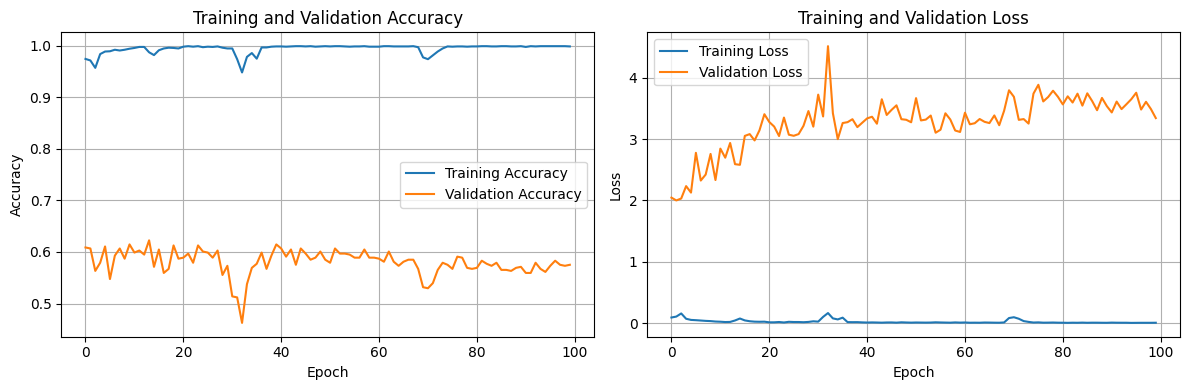

✔ 訓練履歴のプロットを完了しました。


In [12]:
plot_training_history(history)
print("✔ 訓練履歴のプロットを完了しました。")

In [17]:
pwd

'/home/doi/kougi/jissen'

In [18]:
# modelsディレクトリが存在しない場合は作成
os.makedirs('models', exist_ok=True)

# モデルの保存
model_save_path = 'models/simple_garbage_model_6class.h5'
model.save(model_save_path)
print(f"💾 モデルを保存しました: {model_save_path}")

# クラス名を保存（predict.pyで使用するため）
class_names_path = 'models/class_names_6class.json'
with open(class_names_path, 'w', encoding='utf-8') as f:
    json.dump(class_names, f, ensure_ascii=False)
print(f"💾 クラス名を保存しました: {class_names_path}")

print("✔ モデルとクラス名の保存を完了しました。")

💾 モデルを保存しました: models/simple_garbage_model_6class.h5
💾 クラス名を保存しました: models/class_names_6class.json
✔ モデルとクラス名の保存を完了しました。


🎯 最終テスト損失: 3.3413
🎯 最終テスト精度: 57.51%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

📊 分類レポート:
              precision    recall  f1-score   support

   cardboard       0.73      0.65      0.69        81
       glass       0.53      0.58      0.55       100
       metal       0.48      0.59      0.53        82
       paper       0.64      0.63      0.64       119
     plastic       0.55      0.49      0.52        97
       trash       0.47      0.33      0.39        27

    accuracy                           0.58       506
   macro avg       0.57      0.55      0.55       506
weighted avg       0.58      0.58      0.58       506


📊 混同行列:


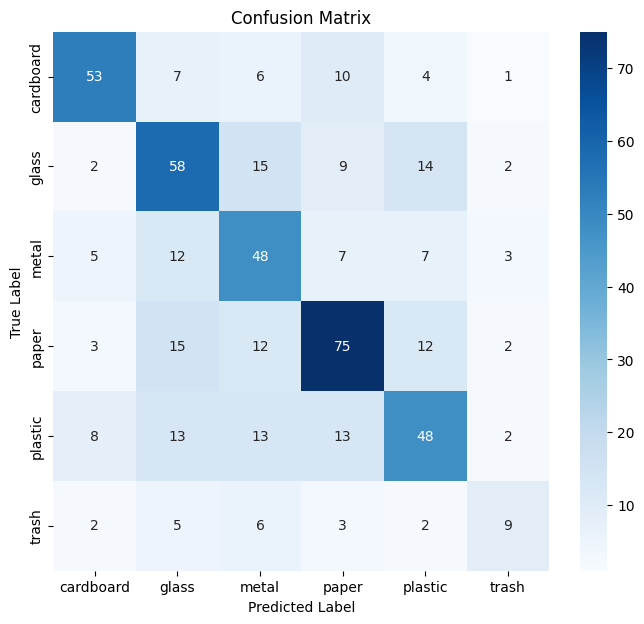

✅ 訓練と評価を完了しました！


In [19]:
# 最終精度を表示
final_loss, final_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"🎯 最終テスト損失: {final_loss:.4f}")
print(f"🎯 最終テスト精度: {final_accuracy:.2%}")

# 混同行列の表示 (テストデータに対する予測)
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # 確率が最も高いクラスのインデックスを取得

print("\n📊 分類レポート:")
# target_names に class_names を渡すことで、レポートにクラス名が表示されます
print(classification_report(y_test, y_pred_classes, target_names=class_names))

print("\n📊 混同行列:")
plot_confusion_matrix(y_test, y_pred_classes, class_names)

print("✅ 訓練と評価を完了しました！")